In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
%matplotlib inline
# large figures
rcParams['figure.figsize'] = 8, 6

2.15.0


/opt/homebrew/Caskroom/miniforge/base/envs/DLMDSDL01/lib/python3.11/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Training dataset shape:  torch.Size([60000, 28, 28])


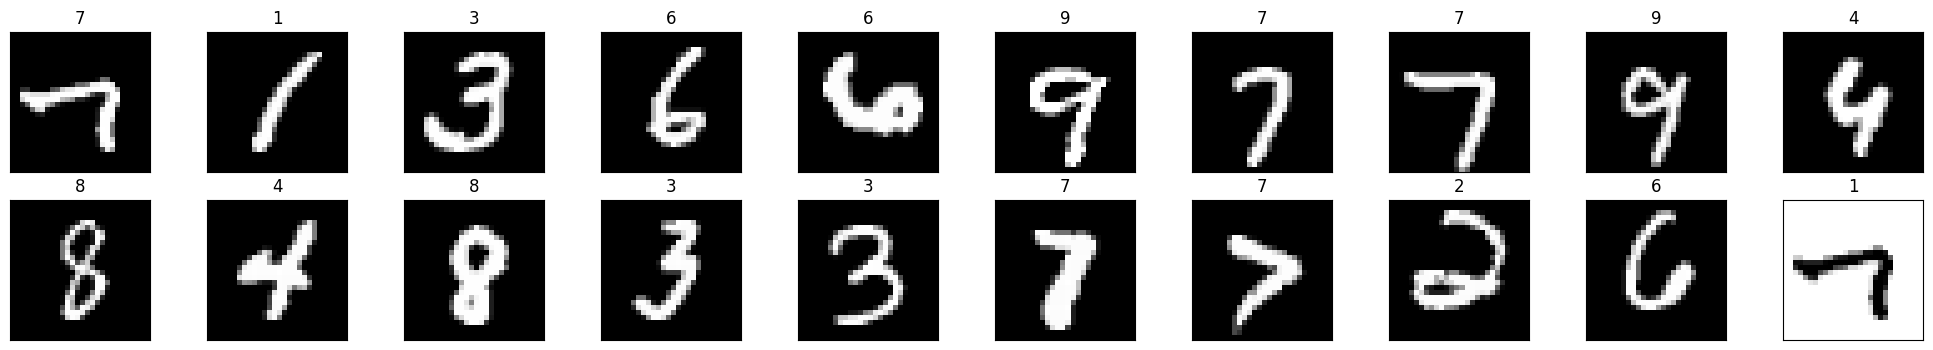

In [3]:
# Import MNIST from Pytorch
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)

# Define the size of the validation set
validation_size = 0.10

# Get the number of data points
num_train = len(trainset)

# List of indices from 0 to num_train
indices = list(range(num_train))

# Shuffle the indices
np.random.shuffle(indices)

# Calculate the number of data points in the validation set
split = int(np.floor(validation_size * num_train))

# Split indices into training and validation sets
train_idx, valid_idx = indices[split:], indices[:split]

# Create data samplers
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=valid_sampler)

# Get the first batch
dataiter = iter(train_loader)

images, labels = next(dataiter)

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].numpy()), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# Print shape of training dataset
print("Training dataset shape: ", trainset.train_data.shape)

In [4]:
# Parameters for training
learning_rate = 1.2e-3
batch_size = 60
epochs = 3

# Validation Calculation
val_check_iter = 3
iterations_per_epoch = len(train_loader)

In [ ]:
def evaluate_validation_set(model, validation_loader, device):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    with torch.no_grad():  # Disable gradient computation
        for x_val, y_val in validation_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            outputs = model(x_val)
            _, predicted = torch.max(outputs.data, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

    accuracy = correct / total
    return accuracy

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the LeNet-300-100 model
class LeNet300100(nn.Module):
    def __init__(self):
        super(LeNet300100, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(784, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10), # Returns logits
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# Create the model
model = LeNet300100()

# Move the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model summary (We'll use torchsummary for a detailed summary)
from torchsummary import summary
summary(model, input_size=(784,))

# Create the optimizer with gradient clipping
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses and gradient norms
losses = []
accuracy_list = []
val_accuracy_list = []
grad_norms = []

for epoch in range(epochs):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Move data to the device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = nn.CrossEntropyLoss()(output, y_batch)
        loss.backward()


        # Calculate and store gradient norm
        total_grad_norm = torch.sqrt(sum(p.grad.norm()**2 for p in model.parameters() if p.grad is not None))
        grad_norms.append(total_grad_norm.item())

        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        # Store the accuracy 
        _, argmax = torch.max(output, 1)
        accuracy = (y_batch == argmax.squeeze()).float().mean()
        accuracy_list.append(accuracy)

        if i % int(len(train_loader) / 50) == 0:
            print(".", end='')

        if i % int(len(train_loader) / val_check_iter) == 0:
            # Calculate validation accuracy at the end of each epoch
            val_accuracy = evaluate_validation_set(model, valid_loader, device)
            val_accuracy_list.append(val_accuracy)
            
            # Calculate average loss and accuracy over an epoch
            avg_loss = torch.mean(torch.tensor(losses[-len(train_loader):]))
            avg_accuracy = torch.mean(torch.tensor(accuracy_list[-len(train_loader):]))
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss.item():.4f}, Accuracy: {avg_accuracy.item():.4f}, Val Accuracy: {val_accuracy:.4f}')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------
.....................................................Epoch 1/50, Loss: 0.2241, Accuracy: 0.9320
.....................................................Epoch 2/50, Loss: 0.0

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


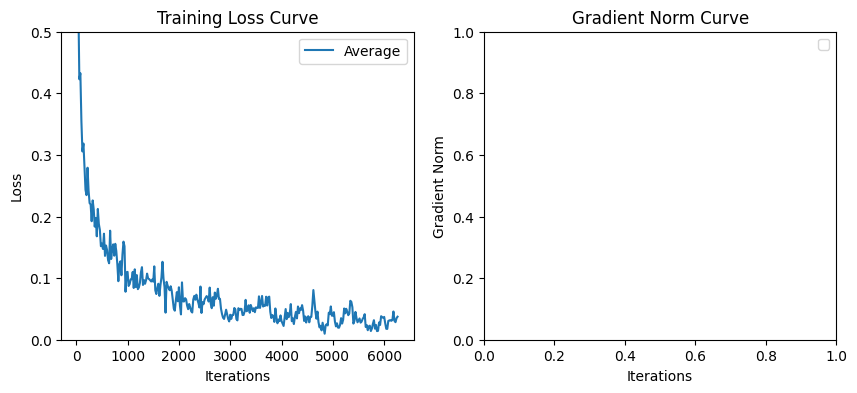

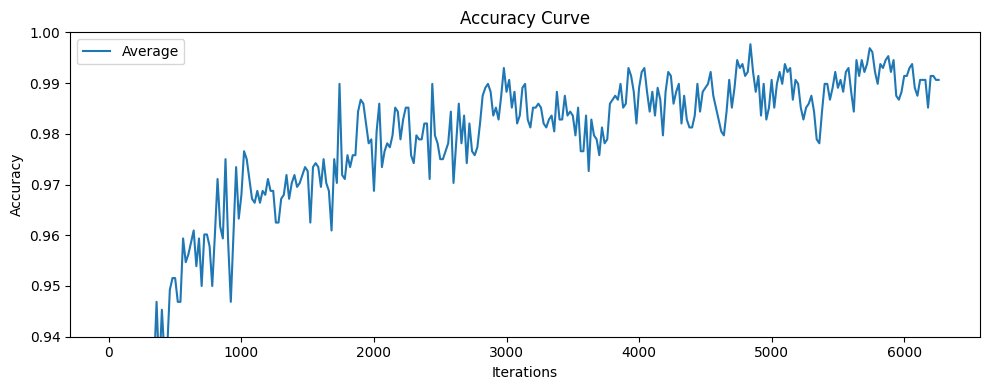

In [29]:
# Copy the tensor to CPU and convert to numpy datatype
losses = torch.tensor(losses).cpu().numpy()
accuracy_list = torch.tensor(accuracy_list).cpu().numpy()
grad_norms = torch.tensor(grad_norms).cpu().numpy()

# Create averages of size 20
average_window = 20
average_losses = [np.mean(losses[i-average_window:i]) for i in range(0, len(losses), average_window)]
avg_accuracy_list = [np.mean(accuracy_list[i-average_window:i]) for i in range(0, len(accuracy_list), average_window)]
avg_grad_norms = [np.mean(grad_norms[i-average_window:i]) for i in range(0, len(grad_norms), average_window)]

# Create an x-axis variable for plotting
iterations = np.arange(len(average_losses)) * average_window

# Plotting the loss curve (average, with max and min as error bands)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(iterations, average_losses, label='Average')

plt.ylim(0, .5)

plt.title('Training Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# Plotting the gradient norm curve
plt.subplot(1, 2, 2)
plt.plot(iterations, avg_grad_norms, label='Average')
plt.title('Gradient Norm Curve')
plt.xlabel('Iterations')
plt.ylabel('Gradient Norm')
plt.legend()

# Plotting the accuracy curve (average, with max and min as error bars)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(iterations, avg_accuracy_list, label='Average')
plt.title('Training Accuracy Curve')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the validation accuracy curve
x_iterations = np.arange(0, iterations_per_epoch * epochs,(iterations_per_epoch * epochs) /len(val_accuracy_list))
plt.subplot(1, 2, 2)
plt.plot(x_iterations, val_accuracy_list, label='Average')
plt.title('Validation Accuracy Curve')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

# Zoom to 0.94 to 1.0 range
plt.ylim(0.94, 1.0)

plt.tight_layout()
plt.show()

In [31]:
# Test the model
model.eval()
test_loss = 0
correct = 0

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_batch)
        test_loss += nn.CrossEntropyLoss()(output, y_batch).item()

        _, argmax = torch.max(output, 1)
        correct += (y_batch == argmax.squeeze()).float().sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset)

print(f'Test loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

AttributeError: 'Sequential' object has no attribute 'eval'

# 